In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import os
import talib
import factors
import labeling
from tree import train_ensemble, evaluate_ensemble, get_predicted_label_sequence

In [2]:
data_dir = r"D:\360MoveData\Users\liujunyuan\Desktop\QTS\Crypto_trading_technical_indicators\data\cpt_5min\k_data"

pkl_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]

data_dict = {}
for file in pkl_files:
    file_path = os.path.join(data_dir, file)
    data_dict[file] = pd.read_pickle(file_path)


In [3]:
file_list = ['ADAUSDT.pkl', 'ATOMUSDT.pkl', 'AVAXUSDT.pkl', 'BNBUSDT.pkl', 'BTCUSDT.pkl',
             'DOGEUSDT.pkl', 'ETHUSDT.pkl', 'LTCUSDT.pkl', 'SHIBUSDT.pkl', 'SOLUSDT.pkl', 'VETUSDT.pkl']

names = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'ETH', 'LTC', 'SHIB', 'SOL', 'VETI']

for name, file in zip(names, file_list):
    globals()[name] = data_dict.get(file)
ADA.head()

,open,high,low,close,preclose,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
date,,,,,,,,,,,,
2022-01-01 06:00:00,1.32708,1.32945,1.32500,1.32500,NaN,17533.4,1641017099999,23275.65924000,17,5127.50000000,6813.51183600,0
2022-01-01 06:05:00,1.32495,1.32505,1.32135,1.32359,1.32500,27696.9,1641017399999,36660.37987400,61,7316.20000000,9683.86631400,0
2022-01-01 06:10:00,1.32354,1.32470,1.32160,1.32328,1.32359,27201.9,1641017699999,36007.88924000,34,14715.50000000,19483.17691000,0
2022-01-01 06:15:00,1.32286,1.32286,1.32046,1.32046,1.32328,4896.0,1641017999999,6468.43729200,10,780.00000000,1031.83080000,0
2022-01-01 06:20:00,1.32050,1.32050,1.31991,1.31991,1.32046,1806.7,1641018299999,2385.70016900,6,34.10000000,45.02359400,0


In [4]:
start = "2022-01-01 06:00:00"
end = "2024-12-31 06:00:00"

df_with_indicators = factors.compute_technical_indicators(BTC, start, end)
df_result = df_with_indicators.iloc[120:].copy()

labels = labeling.generate_labels(BTC, price_col='close')
labels = labels.iloc[120:]


df_final = df_result.copy()
df_final['label'] = labels
df_final = df_final.infer_objects(copy=False)
pd.set_option('future.no_silent_downcasting', True)
df_final.fillna(0, inplace=True)
print(df_final.tail())

                         open      high       low     close  preclose  \
date                                                                    
2024-12-31 05:40:00  92712.77  92765.67  92706.02  92765.67  92706.00   
2024-12-31 05:45:00  92706.01  92706.01  92628.33  92628.33  92765.67   
2024-12-31 05:50:00  92631.22  92631.22  92631.22  92631.22  92628.33   
2024-12-31 05:55:00  92704.74  92704.74  92704.74  92704.74  92631.22   
2024-12-31 06:00:00  92634.43  92634.58  92634.43  92634.58  92704.74   

                      volume     close_time quote_asset_volume  \
date                                                             
2024-12-31 05:40:00  0.21924  1735623899999     20336.78566040   
2024-12-31 05:45:00  0.03127  1735624199999      2898.90276270   
2024-12-31 05:50:00  0.00054  1735624499999        50.02085880   
2024-12-31 05:55:00  0.00017  1735624799999        15.75980580   
2024-12-31 06:00:00  0.01198  1735625099999      1109.76051790   

                     numb

In [5]:
train_size = int(len(df_final) * 0.75)
train_df = df_final.iloc[:train_size].copy()
test_df = df_final.iloc[train_size:].copy()

print("Training Dataset Size:", train_df.shape[0])
print("Test Dataset Size:", test_df.shape[0])

Training Dataset Size: 236361
Test Dataset Size: 78788


In [6]:
trees = train_ensemble(train_df)

train_acc = evaluate_ensemble(trees, train_df)
print("Train Accuracy:", train_acc)

test_acc = evaluate_ensemble(trees, test_df)
print("Test Accuracy:", test_acc)

predicted_labels_series = get_predicted_label_sequence(trees, test_df)
test_df = test_df.copy()
test_df['predicted_label'] = predicted_labels_series
test_df[['label', 'predicted_label']].tail()

Training trees: 100%|████████████████████████████████████████████████████████████████| 100/100 [14:28<00:00,  8.68s/it]


Train Accuracy: 1.0
Test Accuracy: 0.2605092146012083


,label,predicted_label
date,,
2024-12-31 05:40:00,-2,-1
2024-12-31 05:45:00,0,2
2024-12-31 05:50:00,1,-1
2024-12-31 05:55:00,-1,-2
2024-12-31 06:00:00,0,2


In [7]:
def compute_return_stats(df, label='returns'):
    df = df.copy()
    df[label] = df['close'].pct_change()
    df = df.dropna()

    r_mean = df[label].mean()
    r_std = df[label].std()

    # Annualized volatility: daily standard deviation multiplied by sqrt(365)
    annualized_vol = r_std * np.sqrt(365)
    
    # Annualized geometric average return: ((∏(1 + r))^(365/n)) - 1
    rG = (df[label].add(1).prod())**(365/len(df)) - 1

    # Annualized arithmetic average return: ((1 + r_mean)^365) - 1
    rA = (1 + r_mean)**365 - 1

    # Information Ratios: ratio of annualized returns to annualized volatility
    ir_geom = rG / annualized_vol if annualized_vol != 0 else np.nan
    ir_arith = rA / annualized_vol if annualized_vol != 0 else np.nan

    stats = {
        'Average Daily Return': r_mean,
        'Daily Volatility': r_std,
        'Annualized Volatility': annualized_vol,
        'Annualized Geometric Average Return (rG)': rG,
        'Annualized Arithmetic Average Return (rA)': rA,
        'Information Ratio (rG)': ir_geom,
        'Information Ratio (rA)': ir_arith
    }
    return pd.Series(stats)

# Compute summary statistics for full sample, training sample, and test sample
full_stats = compute_return_stats(df_final)
train_stats = compute_return_stats(train_df)
test_stats = compute_return_stats(test_df)

# Concatenate summary statistics into one table
summary_table = pd.concat([full_stats, train_stats, test_stats], axis=1)
summary_table.columns = ['Full Sample', 'Training Sample', 'Test Sample']
print("Return Summary Statistics:")
display(summary_table)

Return Summary Statistics:


,Full Sample,Training Sample,Test Sample
Average Daily Return,0.000004,0.000003,0.000005
Daily Volatility,0.001694,0.001724,0.001601
Annualized Volatility,0.032370,0.032944,0.030583
Annualized Geometric Average Return (rG),0.000779,0.000575,0.001391
Annualized Arithmetic Average Return (rA),0.001304,0.001118,0.001859
Information Ratio (rG),0.024079,0.017463,0.045468
Information Ratio (rA),0.040277,0.033943,0.060785


In [8]:
def count_labels(df):
    counts = df['label'].value_counts().sort_index()
    return counts

full_label_counts = count_labels(df_final)
train_label_counts = count_labels(train_df)
test_label_counts = count_labels(test_df)

trend_table = pd.DataFrame({
    'Full Sample': full_label_counts,
    'Training Sample': train_label_counts,
    'Test Sample': test_label_counts
})
trend_table.index.name = 'Label'
print("Trend Statistics:")
display(trend_table)

Trend Statistics:


,Full Sample,Training Sample,Test Sample
Label,,,
-2,55095,39780,15315
-1,70208,54699,15509
0,62850,46259,16591
1,71301,55434,15867
2,55695,40189,15506


In [9]:
# 1. In-sample (Training set) performance statistics
# ----------------------------
train_perf = train_df.copy()
train_perf['next_return'] = train_perf['close'].shift(-1) / train_perf['close'] - 1
train_perf = train_perf.dropna()  # Remove the last row (no next period)

# Get ensemble predicted labels for training set (labels: -2, -1, 0, 1, 2)
predicted_train = get_predicted_label_sequence(trees, train_perf)

# Define trading signals:
# Long signals: 1 and 2; Short signals: -2 and -1.
long_signals = [1, 2]
short_signals = [-2, -1]

performance_train = {}

# For long signals: win_ratio = proportion with next_return > 0, loss_ratio = proportion with next_return < 0.
for signal in long_signals:
    mask = (predicted_train == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (train_perf.loc[mask, 'next_return'] > 0).mean()
        loss_ratio = (train_perf.loc[mask, 'next_return'] < 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_train[signal] = {'n_trades': n_trades, 
                                 'win_ratio': win_ratio, 
                                 'loss_ratio': loss_ratio}

# For short signals: win_ratio = proportion with next_return < 0, loss_ratio = proportion with next_return > 0.
for signal in short_signals:
    mask = (predicted_train == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (train_perf.loc[mask, 'next_return'] < 0).mean()
        loss_ratio = (train_perf.loc[mask, 'next_return'] > 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_train[signal] = {'n_trades': n_trades, 
                                 'win_ratio': win_ratio, 
                                 'loss_ratio': loss_ratio}

perf_train_df = pd.DataFrame(performance_train).T.sort_index()
print("In-sample (Training set) trading performance (n_trades, win_ratio, loss_ratio):")
display(perf_train_df)

In-sample (Training set) trading performance (n_trades, win_ratio, loss_ratio):


,n_trades,win_ratio,loss_ratio
-2,39780.0,1.0,0.0
-1,54699.0,1.0,0.0
1,55433.0,1.0,0.0
2,40189.0,1.0,0.0


In [10]:
# 2. Out-of-sample (Test set) performance and simulated trading
# ----------------------------
test_perf = test_df.copy()
test_perf['next_return'] = test_perf['close'].shift(-1) / test_perf['close'] - 1
test_perf = test_perf.dropna()

# Get ensemble predicted labels for test set
predicted_test = get_predicted_label_sequence(trees, test_perf)

performance_test = {}

for signal in long_signals:
    mask = (predicted_test == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (test_perf.loc[mask, 'next_return'] > 0).mean()
        loss_ratio = (test_perf.loc[mask, 'next_return'] < 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_test[signal] = {'n_trades': n_trades, 
                                'win_ratio': win_ratio, 
                                'loss_ratio': loss_ratio}

for signal in short_signals:
    mask = (predicted_test == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (test_perf.loc[mask, 'next_return'] < 0).mean()
        loss_ratio = (test_perf.loc[mask, 'next_return'] > 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_test[signal] = {'n_trades': n_trades, 
                                'win_ratio': win_ratio, 
                                'loss_ratio': loss_ratio}

perf_test_df = pd.DataFrame(performance_test).T.sort_index()
print("Out-of-sample (Test set) trading performance (n_trades, win_ratio, loss_ratio):")
display(perf_test_df)

Out-of-sample (Test set) trading performance (n_trades, win_ratio, loss_ratio):


,n_trades,win_ratio,loss_ratio
-2,19006.0,0.505314,0.470378
-1,22304.0,0.509460,0.428533
1,13151.0,0.516843,0.430233
2,17926.0,0.519971,0.459165


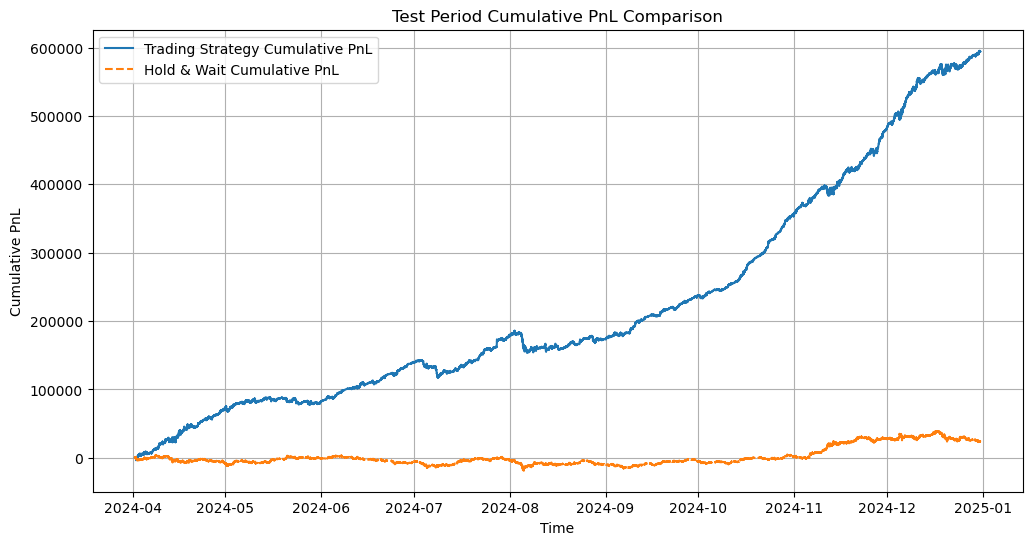

In [11]:
test_trading = test_df.copy()
test_trading['position'] = predicted_test.astype(float)
test_trading['pnl'] = test_trading['position'] * (test_trading['close'].shift(-1) - test_trading['close'])
test_trading = test_trading.dropna(subset=['pnl'])
test_trading['cumulative_pnl'] = test_trading['pnl'].cumsum()

# ----------------------------
# 2. Hold & Wait Strategy Simulation
# ----------------------------
test_hold = test_df.copy()
initial_price = test_hold['close'].iloc[0]
test_hold['pnl'] = test_hold['close'] - initial_price

plt.figure(figsize=(12, 6))
plt.plot(test_trading.index, test_trading['cumulative_pnl'], label='Trading Strategy Cumulative PnL')
plt.plot(test_hold.index, test_hold['pnl'], label='Hold & Wait Cumulative PnL', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Test Period Cumulative PnL Comparison')
plt.legend()
plt.grid(True)
plt.show()

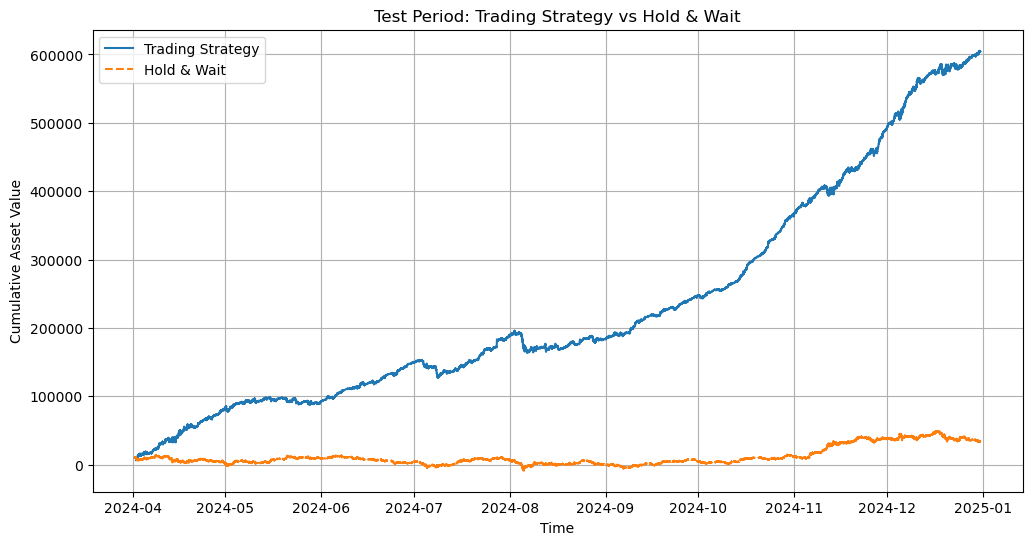

In [13]:
def simulate_trading(series_close, series_signal, initial_cash=10000, fee_rate=0.0002):
    """
    Simulate trading based on predicted signals.
    
    Parameters:
      series_close: pd.Series, asset close prices (indexed by time)
      series_signal: pd.Series, trading signals (predicted label, with values in {-2, -1, 0, 1, 2})
      initial_cash: initial cash amount (default 10000)
      fee_rate: transaction fee rate applied on both entry and exit
      
    Trading rule (per period):
      - If signal > 0: buy 'signal' units at current close, and sell at next period's close.
      - If signal < 0: short |signal| units at current close, and cover at next period's close.
      - If signal == 0: do nothing.
      
    Fee is applied on both the entry and exit transactions.
    
    Returns:
      time_index: index corresponding to each trade (using current period index)
      asset_values: list of cumulative asset values after each trade.
    """
    cash = initial_cash
    asset_values = []
    
    # Combine close prices and signals into a DataFrame
    df = pd.concat([series_close, series_signal], axis=1)
    df.columns = ["close", "Signal"]
    
    # We simulate trades from period 0 to period N-2 (since last period has no next close)
    for i in range(len(df) - 1):
        price = df["close"].iloc[i]
        signal = df["Signal"].iloc[i]
        # If signal is 0, no trade; asset value remains unchanged.
        if signal != 0:
            next_price = df["close"].iloc[i+1]
            # Compute trade value = abs(signal) * price
            trade_value_entry = abs(signal) * price
            fee_entry = trade_value_entry * fee_rate
            trade_value_exit = abs(signal) * next_price
            fee_exit = trade_value_exit * fee_rate
            # For a long trade (signal > 0): pnl = signal*(next_price - price) - fees
            # For a short trade (signal < 0): pnl = abs(signal)*(price - next_price) - fees
            if signal > 0:
                pnl = signal * (next_price - price) - fee_entry - fee_exit
            else:
                pnl = abs(signal) * (price - next_price) - fee_entry - fee_exit
            cash += pnl
        asset_values.append(cash)
    
    # For plotting purposes, use the index from period 0 to len(df)-1
    time_index = df.index[:-1]
    return time_index, asset_values

def simulate_hold(series_close, initial_cash=10000, fee_rate=0.0002):
    """
    Simulate a hold & wait strategy: buy 1 unit at the beginning and hold until the end.
    
    Parameters:
      series_close: pd.Series, asset close prices (indexed by time)
      initial_cash: initial cash (default 10000)
      fee_rate: transaction fee rate (applied on entry and exit)
      
    Returns:
      time_index: same as series_close index
      asset_values: cumulative asset values (cash + position * close price).
    """
    # Buy 1 unit at the first period
    initial_price = series_close.iloc[0]
    trade_value_entry = initial_price
    fee_entry = trade_value_entry * fee_rate
    # Cash after purchase:
    cash = initial_cash - (trade_value_entry + fee_entry)
    # Position is 1 unit
    position = 1
    asset_values = []
    for price in series_close:
        asset_value = cash + position * price
        asset_values.append(asset_value)
    return series_close.index, asset_values

# ----------------------------
# Using our test set and predicted label (predicted_test)
# ----------------------------
# predicted_test 已经与 test_df 对齐，是我们的交易信号（取值：-2, -1, 0, 1, 2）
# For our simulation, ensure test_df has no NaN in 'close'
test_series_close = test_df['close']

# Simulate our trading strategy based on predicted signals
time_idx, strategy_asset = simulate_trading(test_series_close, predicted_test, initial_cash=10000, fee_rate=0.0)

# Simulate hold & wait strategy
hold_time_idx, hold_asset = simulate_hold(test_series_close, initial_cash=10000, fee_rate=0.0)

# Plot cumulative asset curves
plt.figure(figsize=(12, 6))
plt.plot(time_idx, strategy_asset, label='Trading Strategy')
plt.plot(hold_time_idx, hold_asset, label='Hold & Wait', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cumulative Asset Value')
plt.title('Test Period: Trading Strategy vs Hold & Wait')
plt.legend()
plt.grid(True)
plt.show()